In [1]:
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

### Formulation of the problem

For an image consisting of a road sign, predict the bounding box around the road sign and determine the type of road sign.
These signs can belong to four different classes:
* Traffic light
* Stop
* Speed ​​limit
* Crosswalk

This is called a multitasking learning task because it involves performing two tasks:
1) regression to find the coordinates of the bounding box,
2) classification to determine the type of road sign.

### Dataset

It consists of 877 images. This is a rather unbalanced dataset, most of the images are in the rate limiting class, but since we are more focused on predicting the bounding box, we can ignore the imbalance.

### Loading data

Descriptions for each image are stored in separate XML files. Let's take the following steps to prepare data for training:
* Walk through the annotations directory to get all the .xml files
* Read the information we need from each .xml file using xml.etree.ElementTree
* Create a dictionary containing filepath(path to image), width, height, (xmin , xmax , ymin , ymax) (bounding box's coordinates) and class and add the dictionary to the list.
* Create a pandas dataframe using the list of dictionaries from the previous paragraph

In [2]:
images_path = Path('../input/road-sign-detection/images')
anno_path = Path('../input/road-sign-detection/annotations')


def filelist(root, file_type):
    """The function returns a fully qualified list of files in a directory."""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]


def generate_train_df (anno_path):
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = Path(str(images_path) + '/'+ root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = root.find("./object/name").text
        anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [3]:
df_train = generate_train_df(anno_path)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,../input/road-sign-detection/images/road732.png,300,400,speedlimit,99,97,159,157
1,../input/road-sign-detection/images/road518.png,300,400,speedlimit,157,165,184,191
2,../input/road-sign-detection/images/road717.png,300,400,speedlimit,90,219,109,240
3,../input/road-sign-detection/images/road362.png,300,400,speedlimit,82,164,151,232
4,../input/road-sign-detection/images/road492.png,300,400,speedlimit,110,137,182,208
...,...,...,...,...,...,...,...,...
872,../input/road-sign-detection/images/road248.png,300,400,speedlimit,167,205,192,229
873,../input/road-sign-detection/images/road227.png,300,400,speedlimit,141,181,153,193
874,../input/road-sign-detection/images/road660.png,300,400,speedlimit,132,189,193,250
875,../input/road-sign-detection/images/road620.png,300,400,speedlimit,123,222,150,250


In [4]:
df_train['class'].value_counts()

speedlimit      652
crosswalk        88
stop             76
trafficlight     61
Name: class, dtype: int64


Let's convert our labels into classes:

In [5]:
class_dict = {'speedlimit': 0, 'stop': 1, 'crosswalk': 2, 'trafficlight': 3}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])

print(df_train.shape)
df_train.head()

(877, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,../input/road-sign-detection/images/road732.png,300,400,0,99,97,159,157
1,../input/road-sign-detection/images/road518.png,300,400,0,157,165,184,191
2,../input/road-sign-detection/images/road717.png,300,400,0,90,219,109,240
3,../input/road-sign-detection/images/road362.png,300,400,0,82,164,151,232
4,../input/road-sign-detection/images/road492.png,300,400,0,110,137,182,208


### Resizing images and bounding boxes

Because images need to be the same size to train a computer vision model, we need to resize our images and their corresponding bounding boxes. Resizing an image is easy, but resizing a bounding box is a little trickier because each rectangle depends on the image and its dimensions.

Here is the basic idea:

Let's transform the bounding box into an image (mask) of the same size as the image corresponding to this rectangle. This mask will simply have 0 for the background and 1 for the area covered by the bounding box.

Let's read the image first:

In [6]:
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)


def create_mask(bb, x):
    """Create a mask for the bounding box of the same shape as the image"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y


def mask_to_bb(Y):
    """Convert the Y mask to a bounding box, taking 0 as the background non-null object """
    cols, rows = np.nonzero(Y)
    if len(cols) == 0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)


def create_bb_array(x):
    """Generate bounding box'a array from train_df column"""
    return np.array([x[5],x[4],x[7],x[6]])


def resize_image_bb(read_path, write_path, bb, sz):
    """Resize the image and its bounding box and write the image to a new path"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (sz, sz))
    Y_resized = cv2.resize(create_mask(bb, im), (sz, sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)


Let's apply all our written functions:

In [7]:
IM_SIZE = 300

In [8]:
new_paths = []
new_bbs = []
train_path_resized = Path('./images_resized')
Path.mkdir(train_path_resized, exist_ok=True)


for index, row in df_train.iterrows():
    new_path,new_bb = resize_image_bb(row['filename'], train_path_resized, create_bb_array(row.values), IM_SIZE)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
    
    
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,new_path,new_bb
0,../input/road-sign-detection/images/road732.png,300,400,0,99,97,159,157,images_resized/road732.png,"[72.0, 99.0, 117.0, 158.0]"
1,../input/road-sign-detection/images/road518.png,300,400,0,157,165,184,191,images_resized/road518.png,"[123.0, 157.0, 143.0, 183.0]"
2,../input/road-sign-detection/images/road717.png,300,400,0,90,219,109,240,images_resized/road717.png,"[164.0, 90.0, 179.0, 108.0]"
3,../input/road-sign-detection/images/road362.png,300,400,0,82,164,151,232,images_resized/road362.png,"[123.0, 82.0, 173.0, 150.0]"
4,../input/road-sign-detection/images/road492.png,300,400,0,110,137,182,208,images_resized/road492.png,"[102.0, 110.0, 155.0, 181.0]"



### An example of the resulting sample


(225, 400, 3)


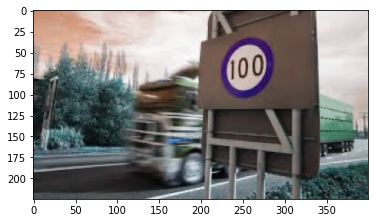

In [9]:
im = cv2.imread(str(df_train.values[58][0]))
bb = create_bb_array(df_train.values[58])
print(im.shape)

Y = create_mask(bb, im)
mask_to_bb(Y)

plt.imshow(im)

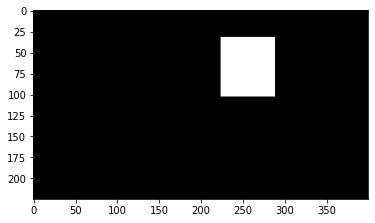

In [10]:
plt.imshow(Y, cmap='gray')

### Data augmentation

Data augmentation is a technique to better generalize our model by generating new training images using different variants of existing images. Our current training set only has 800 images, so data augmentation is very important to keep our model from overfitting.
For this task, we will use flip, rotate, center crop and random crop.

The only thing to remember here is to make sure that the bounding box also transforms in the same way as the image. To do this, we follow the same approach as resizing - we transform the bounding box into a mask, apply the same transformations to the mask as the original image, and extract the coordinates of the bounding box.

In [11]:
# Вырезаем кусок с изображения
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# Центральное вырезание 
def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT):
    """Rotating our image"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M, (c, r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im, M, (c, r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS)

def random_cropXY(x, Y, r_pix=8):
    """Returns a random cut"""
    r, c,*_ = x.shape
    c_pix = round(r_pix * c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2 * rand_r * r_pix).astype(int)
    start_c = np.floor(2 * rand_c * c_pix).astype(int)
    xx = crop(x, start_r, start_c, r - 2*r_pix, c - 2*c_pix)
    YY = crop(Y, start_r, start_c, r - 2*r_pix, c - 2*c_pix)
    return xx, YY

# Трансформируем нашу картинку 
def transformsXY(path, bb, is_transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB) / 255
    Y = create_mask(bb, x)
    if is_transforms:
        rdeg = (np.random.random()-.50) * 20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

### Image example

Original:



images_resized/road856.png


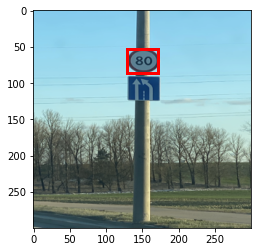

In [12]:
number = 45
im = cv2.imread(str(df_train['new_path'].values[number]))
print(str(df_train.values[number][8]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, df_train['new_bb'].values[number])


After transformation:

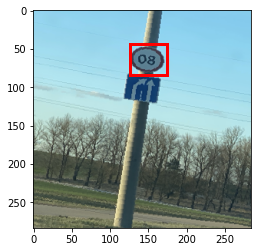

In [13]:
im, bb = transformsXY(str(df_train['new_path'].values[number]),
                      df_train['new_bb'].values[number],
                      is_transforms=True)
show_corner_bb(im, bb)

### Dataset

Now that we have our data additions, we can create a PyTorch dataset. We normalize the images with ImageNet statistics because we will use a pre-trained ResNet model and apply data augmentation on our dataset during training.


In [14]:
df_train = df_train.reset_index()
X = df_train[['new_path', 'new_bb']]
Y = df_train['class']
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)


def normalize(im):
    """Нормализация данных с помощью статистики ImageNet"""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0]) / imagenet_stats[1]


class RoadDataset(Dataset):
    def __init__(self, paths, bb, y, is_transforms=False):
        self.is_transforms = is_transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = transformsXY(path, self.bb[idx], self.is_transforms)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

    
train_ds = RoadDataset(X_train['new_path'], X_train['new_bb'], y_train, is_transforms=True)
valid_ds = RoadDataset(X_val['new_path'], X_val['new_bb'], y_val)



Let's load all this into our dataloader:


In [15]:
batch_size = 16
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

### Model definition

We will use a very simple pre-trained model [resNet-34](https://pytorch.org/vision/stable/models.html#torchvision.models.resnet34) as our model. Since we have two tasks here, there are two final layers - the bounding box regression and the image classifier.


In [16]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features = nn.Sequential(*layers)
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

In [17]:
resnet = models.resnet34(pretrained=True)
list(resnet.children())[:8]

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

### Education

To calculate the loss, we need to take into account both the classification loss and the bounding box regression loss, so we use a combination of cross entropy and L1 loss (the sum of all absolute differences between the true value and the predicted coordinates).

In [18]:
model = BB_model().cuda()
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.006)
epochs = 15
model

BB_model(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [19]:
def train():
    for i in range(epochs):

        model.train()
        total = 0
        sum_loss = 0

        for x, y_class, y_bb in train_dl:
            len_batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = y_bb.cuda().float()
            out_class, out_bb = model(x)
            
            # losses
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="sum")
            
            loss = loss_class + loss_bb
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total += len_batch
            sum_loss += loss.item()
        
        train_loss = sum_loss / total

        # Eval
        model.eval()
        val_total = 0
        val_sum_loss = 0
        correct = 0

        for x, y_class, y_bb in valid_dl:
            len_batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = y_bb.cuda().float()
            
            out_class, out_bb = model(x)
            
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="sum")
            loss = loss_class + loss_bb
            
            _, pred = torch.max(out_class, 1)
            correct += (pred == y_class).sum().item()
            
            val_sum_loss += loss.item()
            val_total += len_batch
            
        val_loss = val_sum_loss / val_total
        val_acc = correct / val_total

        print(f"Epoch [{i+1}/{epochs}]. train_loss {train_loss:.3f} val_loss {val_loss:.3f} val_acc {val_acc:.3f}")

In [20]:
train()

Epoch [1/15]. train_loss 503.344 val_loss 1343.680 val_acc 0.756
Epoch [2/15]. train_loss 225.935 val_loss 280.120 val_acc 0.318
Epoch [3/15]. train_loss 148.099 val_loss 153.990 val_acc 0.750
Epoch [4/15]. train_loss 145.001 val_loss 158.225 val_acc 0.739
Epoch [5/15]. train_loss 144.499 val_loss 162.923 val_acc 0.744
Epoch [6/15]. train_loss 143.369 val_loss 148.709 val_acc 0.756
Epoch [7/15]. train_loss 140.347 val_loss 158.461 val_acc 0.761
Epoch [8/15]. train_loss 135.440 val_loss 165.685 val_acc 0.693
Epoch [9/15]. train_loss 138.219 val_loss 158.399 val_acc 0.761
Epoch [10/15]. train_loss 132.028 val_loss 189.347 val_acc 0.784
Epoch [11/15]. train_loss 130.652 val_loss 143.713 val_acc 0.761
Epoch [12/15]. train_loss 129.853 val_loss 134.483 val_acc 0.790
Epoch [13/15]. train_loss 128.930 val_loss 135.029 val_acc 0.767
Epoch [14/15]. train_loss 128.207 val_loss 135.045 val_acc 0.761
Epoch [15/15]. train_loss 124.919 val_loss 132.862 val_acc 0.778




Trick: after passing the tutorial, we can change the training step and continue:



In [21]:
for i, param_group in enumerate(optimizer.param_groups):
    param_group["lr"] = 0.001

In [22]:
train()

Epoch [1/15]. train_loss 120.614 val_loss 123.771 val_acc 0.790
Epoch [2/15]. train_loss 117.055 val_loss 121.016 val_acc 0.801
Epoch [3/15]. train_loss 119.144 val_loss 119.564 val_acc 0.773
Epoch [4/15]. train_loss 117.604 val_loss 125.285 val_acc 0.778
Epoch [5/15]. train_loss 117.283 val_loss 117.840 val_acc 0.795
Epoch [6/15]. train_loss 113.579 val_loss 121.355 val_acc 0.784
Epoch [7/15]. train_loss 113.766 val_loss 117.781 val_acc 0.795
Epoch [8/15]. train_loss 115.341 val_loss 112.868 val_acc 0.778
Epoch [9/15]. train_loss 111.105 val_loss 108.757 val_acc 0.790
Epoch [10/15]. train_loss 112.404 val_loss 111.164 val_acc 0.784
Epoch [11/15]. train_loss 107.204 val_loss 117.803 val_acc 0.773
Epoch [12/15]. train_loss 108.855 val_loss 111.645 val_acc 0.778
Epoch [13/15]. train_loss 105.157 val_loss 108.451 val_acc 0.778
Epoch [14/15]. train_loss 106.244 val_loss 109.556 val_acc 0.784
Epoch [15/15]. train_loss 105.142 val_loss 107.769 val_acc 0.778




# Testing

In [23]:
# resizing test image
im = read_image('./images_resized/road789.png')
Path.mkdir(Path('./road_signs_test'), exist_ok=True)
cv2.imwrite('./road_signs_test/road789.jpg', cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

True

In [24]:
# test Dataset
test_ds = RoadDataset(
    pd.DataFrame([{'path':'./road_signs_test/road789.jpg'}])['path'],
    pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],
    pd.DataFrame([{'y':[0]}])['y']
)
x, y_class, y_bb = test_ds[0]

xx = torch.FloatTensor(x[None,])
xx.shape

torch.Size([1, 3, 284, 284])

In [25]:
# prediction
out_class, out_bb = model(xx.cuda())
out_class, out_bb

(tensor([[ 1.9434, -0.9509, -0.4944, -1.3870]], device='cuda:0',
        grad_fn=<AddmmBackward>),
 tensor([[111.9880, 108.3861, 158.2375, 163.0214]], device='cuda:0',
        grad_fn=<AddmmBackward>))

In [26]:
# predicted class
torch.max(out_class, 1)

torch.return_types.max(
values=tensor([1.9434], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([0], device='cuda:0'))

In [27]:
class_dict

{'speedlimit': 0, 'stop': 1, 'crosswalk': 2, 'trafficlight': 3}

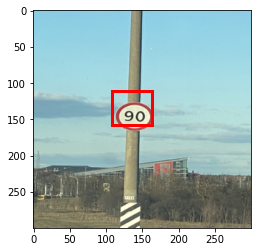

In [28]:
# predicted bounding box
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb(im, bb_hat[0])